[[0.    0.5   0.5   0.   ]
 [0.    0.5   0.    0.5  ]
 [0.    0.    0.5   0.5  ]
 [0.333 0.333 0.333 0.   ]
 [0.    0.    0.5   0.5  ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.5   0.5   0.    0.   ]]


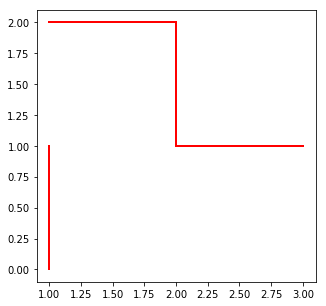

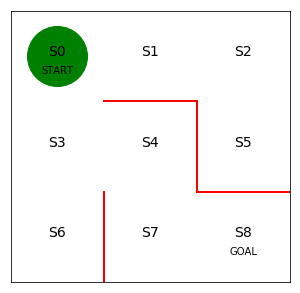

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = plt.gca()

plt.plot([1,1],[0,1],color='red',linewidth=2)
plt.plot([1,2],[2,2],color='red',linewidth=2)
plt.plot([2,2],[2,1],color='red',linewidth=2)
plt.plot([2,3],[1,1],color='red',linewidth=2)

fig = plt.figure(figsize=(5,5))
ax = plt.gca()

plt.plot([1,1],[0,1],color='red',linewidth=2)
plt.plot([1,2],[2,2],color='red',linewidth=2)
plt.plot([2,2],[2,1],color='red',linewidth=2)
plt.plot([2,3],[1,1],color='red',linewidth=2)

plt.text(0.5,2.5,'S0',size=14,ha='center')
plt.text(1.5,2.5,'S1',size=14,ha='center')
plt.text(2.5,2.5,'S2',size=14,ha='center')
plt.text(0.5,1.5,'S3',size=14,ha='center')
plt.text(1.5,1.5,'S4',size=14,ha='center')
plt.text(2.5,1.5,'S5',size=14,ha='center')
plt.text(0.5,0.5,'S6',size=14,ha='center')
plt.text(1.5,0.5,'S7',size=14,ha='center')
plt.text(2.5,0.5,'S8',size=14,ha='center')
plt.text(0.5,2.3,'START',ha='center')
plt.text(2.5,0.3,'GOAL',ha='center')

ax.set_xlim(0,3)
ax.set_ylim(0,3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, right=False, left=False, labelleft=False)

line, = ax.plot([0.5],[2.5],marker="o",color='g',markersize = 60)


theta_0 = np.array([[np.nan, 1, 1, np.nan],
                  [np.nan, 1, np.nan, 1],
                  [np.nan, np.nan, 1, 1],
                  [1, 1, 1, np.nan],
                  [np.nan, np.nan, 1, 1],
                  [1, np.nan, np.nan, np.nan],
                  [1, np.nan, np.nan, np.nan],
                  [1, 1, np.nan, np.nan]
                   ])

def simple_convert_into_pi_from_theta(theta):
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        
    pi = np.nan_to_num(pi)
    
    return pi

def softmax_convert_into_pi_from_theta(theta):
    beta = 1.0
    [m, n] = theta.shape
    pi = np.zeros((m,n))
    
    exp_theta = np.exp(beta * theta)
    
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        
    pi = np.nan_to_num(pi)
    
    return pi


#pi_0 = simple_convert_into_pi_from_theta(theta_0)
pi_0 = softmax_convert_into_pi_from_theta(theta_0)

print(pi_0)

In [12]:
def get_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    
    next_direction = np.random.choice(direction, p=pi[s, :])
    
    if next_direction == "up":
        s_next = s - 3
    elif next_direction == "right":
        s_next = s + 1
    elif next_direction == "down":
        s_next = s + 3
    elif next_direction == "left":
        s_next = s - 1
        
    return s_next

def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    
    next_direction = np.random.choice(direction, p=pi[s, :])
    
    if next_direction == "up":
        action = 0
        s_next = s - 3
    elif next_direction == "right":
        action = 1
        s_next = s + 1
    elif next_direction == "down":
        action = 2
        s_next = s + 3
    elif next_direction == "left":
        action = 3
        s_next = s - 1    
    
    return [action, s_next]
    

def goal_maze(pi):
    s = 0
    state_history = [0]
    
    while(1):
        next_s = get_next_s(pi, s)
        state_history.append(next_s)
        
        if next_s == 8:
            break
        else:
            s = next_s
            
    return state_history

def goal_maze_ret_s_a(pi):
    s = 0
    s_a_history = [[0, np.nan]]
    
    while (1):
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        
        s_a_history.append([next_s, np.nan])
        
        if next_s == 8:
            break
        else:
            s = next_s
            
    return s_a_history

state_history = goal_maze(pi_0)

s_a_history = goal_maze_ret_s_a(pi_0)


#print(state_history)
#print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(state_history) -1 ) +"단계입니다.")

print(s_a_history)
print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) -1 ) +"단계입니다.")


# theta를 수정하는 함수
def update_theta(theta, pi, s_a_history):
    eta = 0.1 #학습률
    T = len(s_a_history) - 1 # 목표 지점에 이르기까지 걸린 단계 수
    
    [m, n] = theta.shape # theta의 행렬 크기를 구함
    delta_theta = theta.copy() # 델타 theta를 구할 준비, 포인터 참조이므로 delta_theta = theta로는 안 됨
    
    # delta_theta를 요소 단위로 계산
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])): # theta 가 nan이 아닌 경우
                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 히스토리에서 상태 i인 것만 모아오는 리스트 컴프리헨션
                
                SA_ij = [SA for SA in s_a_history if SA ==[i,j]]
                # 상태 i에서 행동 j를 취한 경우만 모음
                
                N_i = len(SA_i) # 상태 i에서 모든 행동을 취한 횟수
                N_ij = len(SA_ij) # 상태 i에서 행동 j를 취한 횟수
                
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T
    new_theta = theta + eta * delta_theta
    
    return new_theta

new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)
                
stop_epsilon = 10**-4 # 정책의 변화가 10^-4보다 작아지면 학습을 종료

theta = theta_0
pi = pi_0

is_continue = True
count = 1

while is_continue: # is_continue가 False가 될 때까지 반복
    s_a_history = goal_maze_ret_s_a(pi) # 정책 pi를 따라 미로를 탐색한 히스토리를 구함
    new_theta = update_theta(theta, pi, s_a_history) # 파라미터 theta를 수정
    new_pi = softmax_convert_into_pi_from_theta(new_theta) # 정책 pi를 수정
    
    print(np.sum(np.abs(new_pi - pi))) # 정책의 변화를 출력
    print("목표 지점에 이르기까지 걸린 단계수는 " + str(len(s_a_history) - 1) + "단계입니다.")
    
    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta= new_theta
        pi = new_pi

[[0, 2], [3, 2], [6, 0], [3, 0], [0, 2], [3, 0], [0, 2], [3, 2], [6, 0], [3, 1], [4, 2], [7, 1], [8, nan]]
목표 지점에 이르기까지 걸린 단계 수는 12단계입니다.
[[0.    0.494 0.506 0.   ]
 [0.    0.5   0.    0.5  ]
 [0.    0.    0.5   0.5  ]
 [0.334 0.331 0.334 0.   ]
 [0.    0.    0.502 0.498]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.498 0.502 0.    0.   ]]
0.009815619969069378
목표 지점에 이르기까지 걸린 단계수는 30단계입니다.
0.019170931062375163
목표 지점에 이르기까지 걸린 단계수는 18단계입니다.
0.015552904982881088
목표 지점에 이르기까지 걸린 단계수는 50단계입니다.
0.00887284987411241
목표 지점에 이르기까지 걸린 단계수는 82단계입니다.
0.010945071071931767
목표 지점에 이르기까지 걸린 단계수는 34단계입니다.
0.008940194896510212
목표 지점에 이르기까지 걸린 단계수는 44단계입니다.
0.010969866382244675
목표 지점에 이르기까지 걸린 단계수는 36단계입니다.
0.012916443321208115
목표 지점에 이르기까지 걸린 단계수는 22단계입니다.
0.030694501925739193
목표 지점에 이르기까지 걸린 단계수는 8단계입니다.
0.008235416404520357
목표 지점에 이르기까지 걸린 단계수는 114단계입니다.
0.01448557907546888
목표 지점에 이르기까지 걸린 단계수는 26단계입니다.
0.0271772682758899
목표 지점에 이르기까지 걸린 단계수는 8단계입니다.
0.009016066109487353
목표 지점에 이르기까지 걸린 단

In [13]:
np.set_printoptions(precision=3, suppress=True) #유효 자릿수 3, 지수는 표시하지 않도록 설정
print(pi)

[[0.    0.01  0.99  0.   ]
 [0.    0.28  0.    0.72 ]
 [0.    0.    0.423 0.577]
 [0.01  0.979 0.01  0.   ]
 [0.    0.    0.982 0.018]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.016 0.984 0.    0.   ]]


In [15]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    state = state_history[i]
    x = (state % 3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func = init, frames = len(state_history), interval = 200, repeat = False)

HTML(anim.to_jshtml())

In [18]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    # 프레임 단위로 이미지 생성
    state = s_a_history[i][0] # 현재 위치
    x = ( state % 3 ) + 0.5 # 상태의 x좌표 : 3으로 나눈 나머지 + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x,y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval = 200, repeat = False)

HTML(anim.to_jshtml())